In [7]:
from cgmtools import utils
from cgmtools.forecast import lstm
import datetime
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
import pickle as pkl
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import time

In [5]:
# Load full data set from pickle file (see data_wrangler.py)
dfs_full = pkl.load(open('../../data/dfs_py3.pkl', 'rb'))

# Keep only patients with more than `THRESHOLD` days of CGM acquisition
_threshold = datetime.timedelta(days=3.5)  # default
dfs = utils.filter_patients(dfs_full, _threshold)

In [18]:
burn_in = 300  # burn-in samples used to learn the best order via cv
# n_splits = 15
ph = 18  # prediction horizon
w_size = 36

# Get patients list
patients = list(dfs.keys())

# Iterate on the patients
# for count, idx in enumerate(patients):
count , idx = 0, patients[0]
print("Evaluating patient {}/{}".format(count, len(patients)))
# Train/test split
df = utils.gluco_extract(dfs[idx], return_df=True)
train_df0 = df.iloc[:burn_in]
test_df0 = df.iloc[burn_in:]

# preprocess the dataset
# BEWARE! Do not use the trainig set to learn the scaling parameters
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_df0)
test_data = scaler.transform(test_df0)

# Create LSTM suitable {X, Y} dataset
X_tr, Y_tr = lstm.create_XY_dataset(train_data, window_size=w_size)
X_ts, Y_ts = lstm.create_XY_dataset(test_data, window_size=w_size)

Evaluating patient 0/160


In [23]:
# Create cross-validated LSTM model
param_grid = {'n_units': [4, 8, 16]}

keras_regressor = KerasRegressor(build_fn=lstm.create_model, batch_size=1, verbose=1, nb_epoch=1)
model = GridSearchCV(keras_regressor, param_grid=param_grid)

In [24]:
tic = time.time()
# Fit the model
model.fit(X_tr, Y_tr)
print("Fitting time: {} seconds".format(time.time() - tic))

Epoch 1/1
176/176 [==============================] - 3s      - ETA: 3s

In [ ]:
# Predict the ph and save the errors
tic = time.time()
errs, forecast = lstm.online_forecast(X_ts, Y_ts, model, scaler, ph=18,
                                      verbose=True)
print("Predicting time: {} seconds".format(time.time() - tic))
error_summary = utils.forecast_report(errs)
print(error_summary)
pkl.dump(error_summary, open(idx+'.pkl', 'wb'))
# pkl.dump({'tr_XY': [X_tr, Y_tr],
#           'ts_XY': [X_ts, Y_ts]}, open(idx+'_data_.pkl', 'wb'))
# model.save(idx+'_model_.h5')

Epoch 1/20
264/264 [==============================] - 26s - loss: 0.0015         

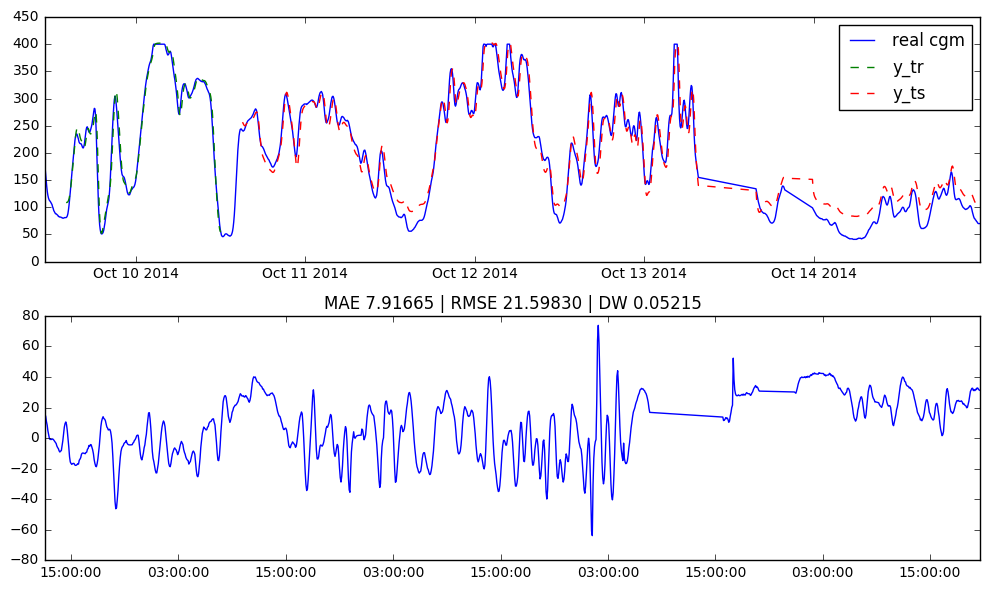

In [5]:
# -- Plotting -- #
import statsmodels.api as sm
import numpy as np
%matplotlib inline

Y_pred_tr = model.predict(X_tr)
Y_pred_ts = model.predict(X_ts)  # maybe its just forecast['ts']
Y_pred_tr_plot = scaler.inverse_transform(Y_pred_tr)
Y_pred_ts_plot = scaler.inverse_transform(Y_pred_ts)
plt.figure(figsize=(10, 6), dpi=300)
plt.subplot(211)
plt.plot(df.index, df.values, label='real cgm')
plt.plot(df.index[w_size:burn_in], Y_pred_tr_plot.ravel(), '--',
         label='y_tr')
plt.plot(df.index[burn_in+w_size:], Y_pred_ts_plot.ravel(), '--',
         label='y_ts')
plt.legend()

residuals = Y_pred_ts_plot.ravel() - df.values[burn_in+w_size:].ravel()
mae = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals ** 2))
DW = sm.stats.durbin_watson(residuals)

plt.subplot(212)
plt.plot(df.index[burn_in:-w_size], residuals)
plt.title("MAE {:2.5f} | RMSE {:2.5f} | DW {:2.5f}".format(mae, rmse, DW))
plt.tight_layout()
# plt.savefig(idx+'.png')